# برنامه شبیه سازی صف بیمارستان
توی این برنامه سعی می کنیم حالت های مختلف صف در مسیر آی سی یو، اتاق عمل و بخش عمومی رو بررسی کنیم. ممکنه من مساله رو اشتباه فهمیده باشم ولی خیلی هم مهم نیست.

از نظر من مساله اینه: یک اتاق آی سی یو داریم با تعدادی تخت و یک بخش عمومی با تعدادی تخت. مسیر اینطوریه که اول بیمار با مشکل حاد به آی سی یو می رسه، بعد در صورتی که در بخش عمومی اتاق خالی داشته باشیم، عمل می شه و به بخش عمومی می ره و بعد از مدتی مرخص می شه.
    
شرایط اینهاست:
    
    - همیشه بیمار منتظر برای بستری شدن در آی سی یو هست
    - اگر در بخش تخت خالی نباشه نمی تونیم کسی رو عمل کنیم در نتیجه از آی سی یو کسی کم نمی شه
    - در ابتدای ورود به بخش یا آی سی یو، مشخص می شه که بیمار حداقل چند روز باید اینجا بمونه. تابع get_random_days اینکار رو انجام می ده و بر اساس یک تابع نرمال
    
کلیت سیستم بر اساس دو دیکشنری کار می کنه:
bakhsh & icu
مثلا 
icu = {0: 3, 1:2, 3:0}
می گه که در آی سی یو سه تخت داریم که در اولی بیماری هست که باید ۳ روز دیگه در آی سی یو بمونه، در دومی بیماری هست که باید ۲ روز در آی سی یو بمونه و در سومی بیماری نیست.

نکته: من فکر می کردم بعد از جراحی هم می رن تو آی سی یو ولی شاید این مساله در تعداد روزهای نیازمند بستری دیده شده و شاید هم نمی رن. به هرحال این یه تمپلیت است و بیمارستان می تونه بنا به نیاز خودش تغییرش بده و تنظیمش کنه

ویدئوی آموزشی این نوت بوک رو از اینجا ببینین: 
[https://www.youtube.com/watch?v=jRASorLrZH4](https://www.youtube.com/watch?v=jRASorLrZH4)

In [1]:
import numpy as np
import matplotlib.pyplot  as plt

مشخص کردن تعداد روزهایی که باید شبیه سازی بشن و تعداد اتاق های مختلفی که می خوایم بررسی کنیم. 

In [64]:
TOTAL_DAYS = 365

BEDS = [(7, 10), (10, 10), (12, 10), (7, 12),] # Four pairs of (BAKHSH, ICU) beds

In [65]:
def empty_bed(room): #is there an empty bed in this room?
    for bed in room:
        if room[bed] == 0:
            return True
    return False

def get_random_days(room): # returns random days for bakhsh or icu. changes the formulas as required
    if room == 'bakhsh':
        days = np.round((np.random.normal(3)+1))
    elif room == 'icu':
        days = np.round((np.random.normal(3)+1))
    else:
        days = np.round((np.random.normal(3)+1))
    if days < 1:
        days = 1
    return days

def add_to_bakhsh(bakhsh): # add one patient to the bakhsh room. we are sure that there is an empty room there
    for i in range(len(bakhsh)):
        if bakhsh[i] == 0:
            bakhsh[i] = get_random_days('bakhsh')
            return


<IPython.core.display.Javascript object>


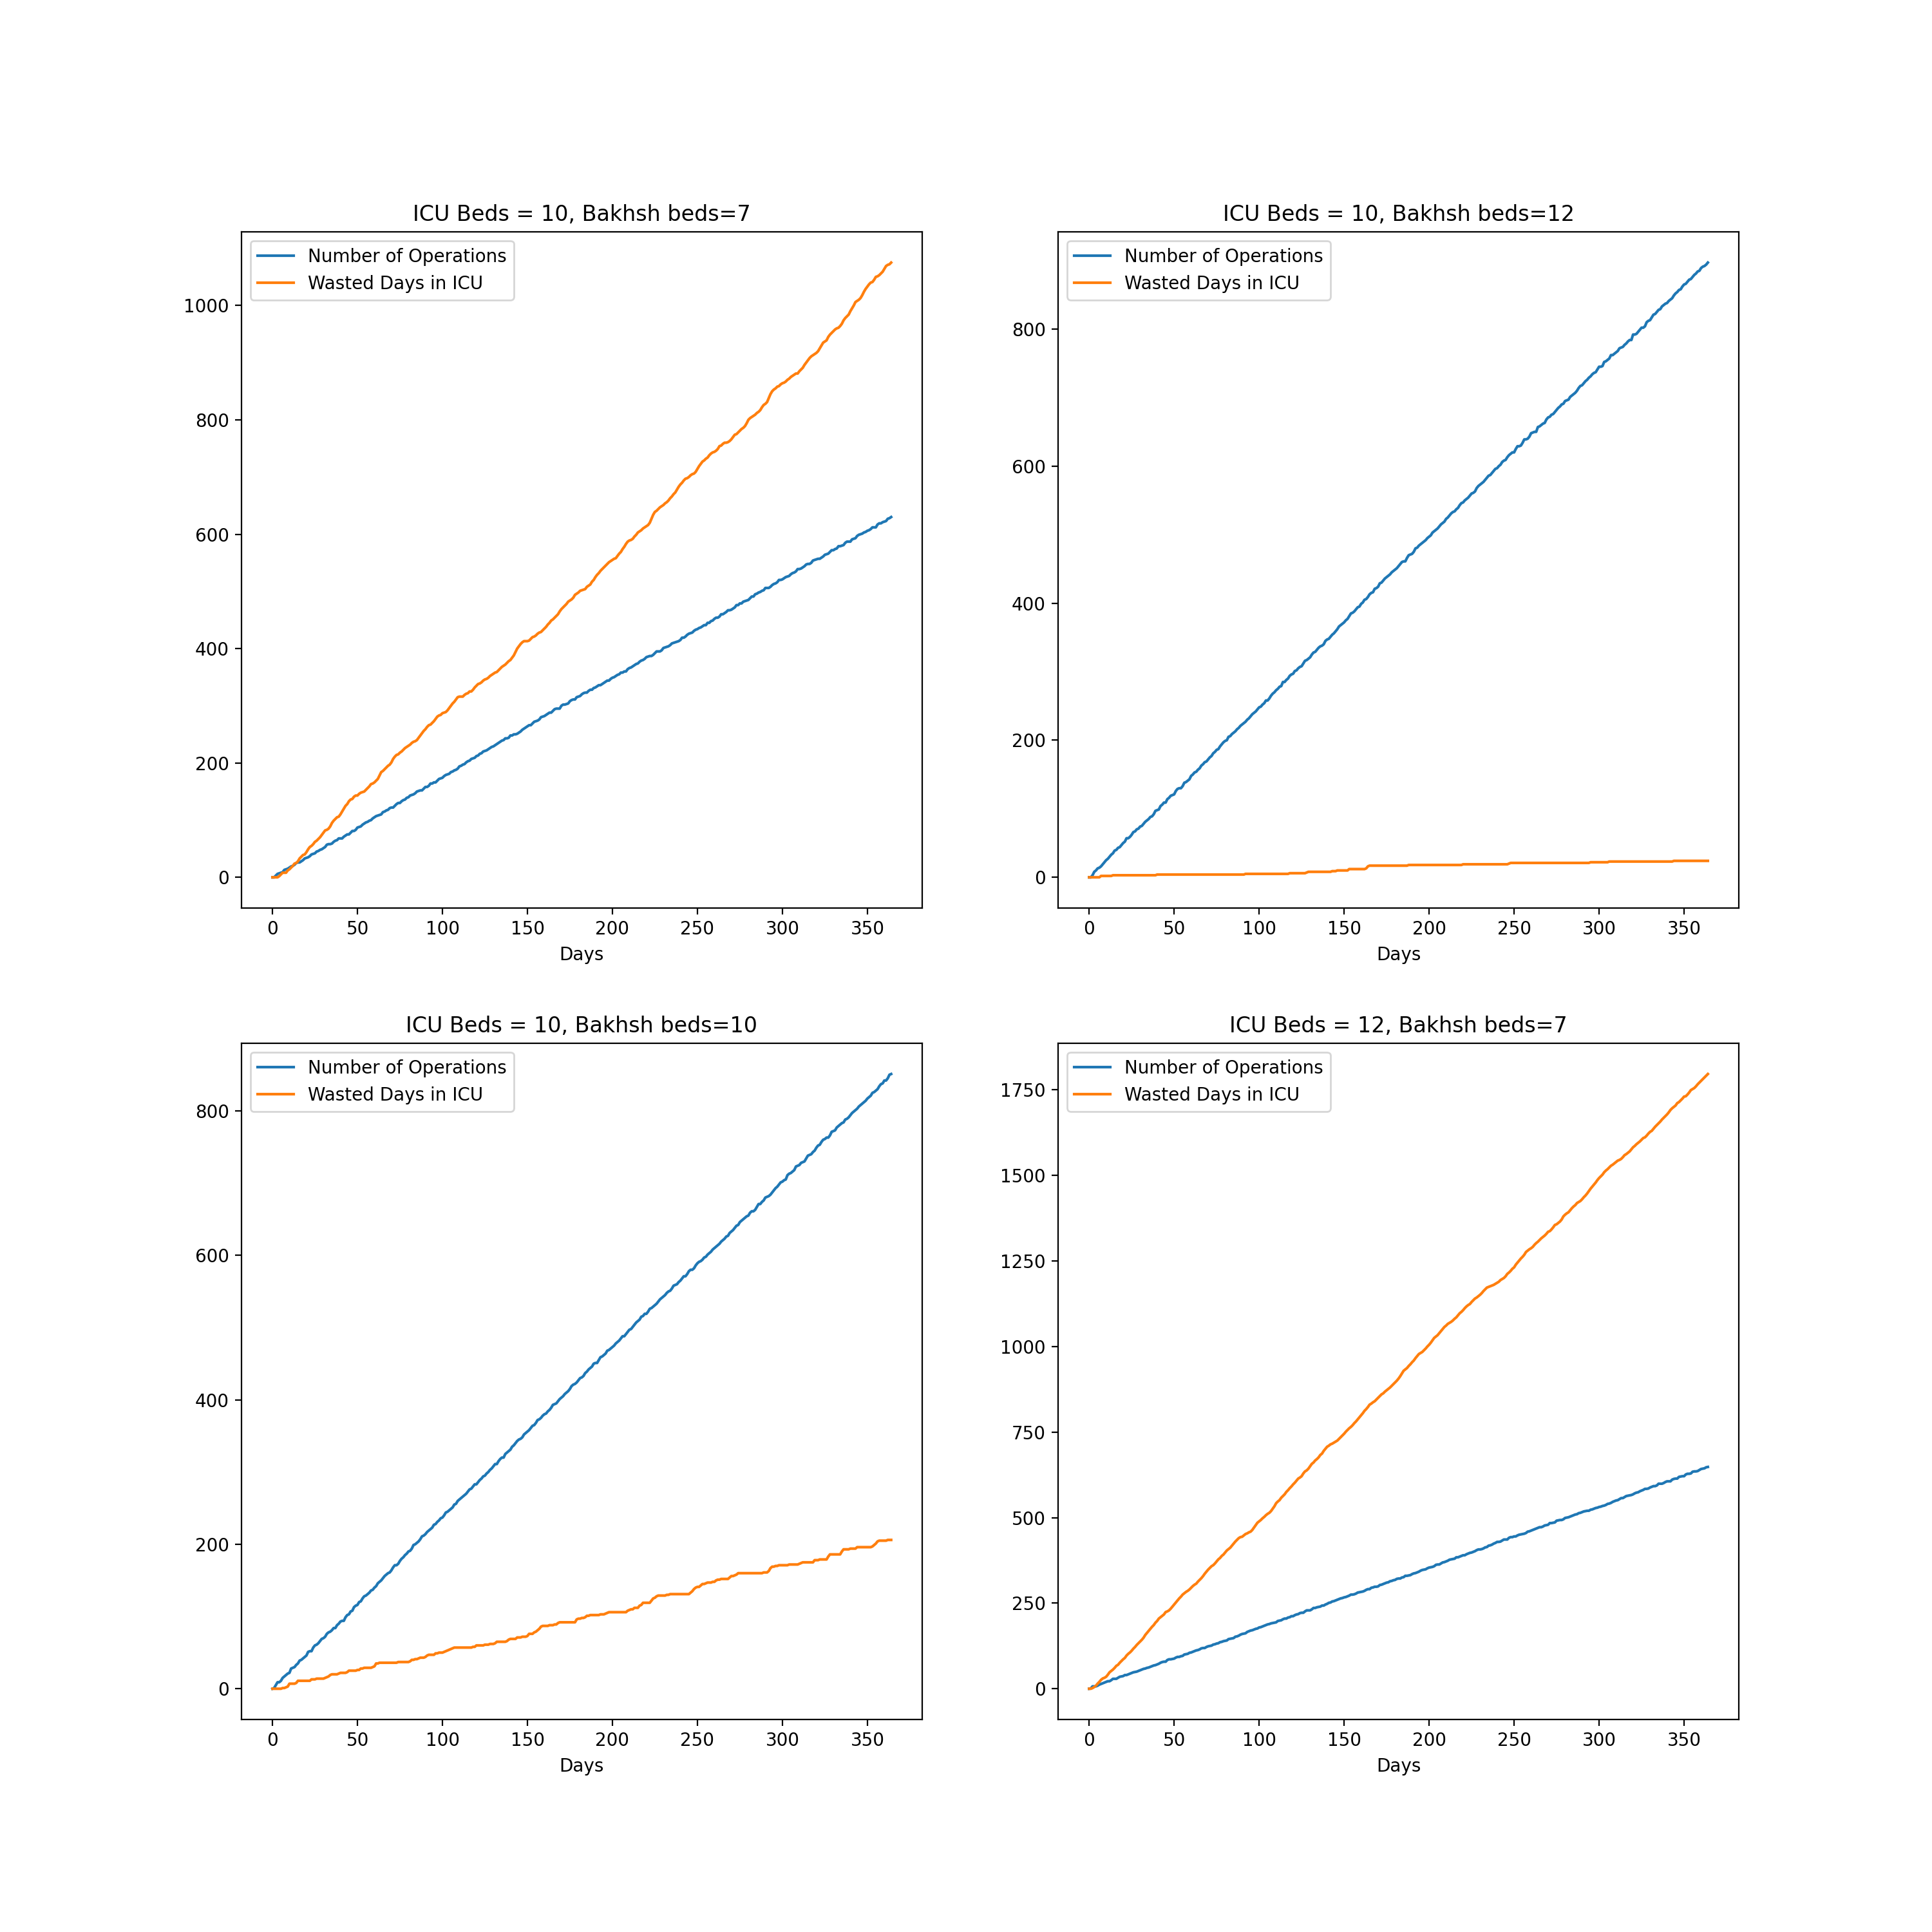

In [66]:
def calculate_performance(beds):
    BAKHSH_BEDS, ICU_BEDS = beds
    
    icu = { key: 0 for key in range(ICU_BEDS)} # empty the ICU
    bakhsh = { key: 0 for key in range(BAKHSH_BEDS)} # empty the Bakhsh
    wasted = np.zeros(TOTAL_DAYS) # number of patients waiting in ICU because there is no bed in BAKHSH
    jarrahi = np.zeros(TOTAL_DAYS) # number of patients went under surgery and moved from ICU to BAKHSH
    
    for day in range(TOTAL_DAYS): # each iteration is simulating one day in the hospital
        for i in range(len(icu)): # if we have an empty bed in ICU, add a patient there.
            if icu[i] == 0:
                icu[i] = get_random_days('icu')
                
        for i in range(len(icu)): # then we check the ICU patients and process them.
            if icu[i] > 1: # if needs to stay more, just deduct one day
                icu[i] -= 1
            else:  # other wise, if there is an empty bed in bakhsh, do the surgery and move the patient to bakhsh
                if empty_bed(bakhsh):
                    jarrahi[day] += 1
                    icu[i] = 0
                    add_to_bakhsh(bakhsh)
                else:
                    wasted[day] += 1

        for i in range(len(bakhsh)): # process the bakhsh: deduct one day from stay time.
            if bakhsh[i] >= 1:
                bakhsh[i] -= 1
                    
    return jarrahi, wasted


chart_counter = 0
fig, ax = plt.subplots(nrows=2, ncols=int(len(BEDS)/2), figsize=(15, 15))

for beds in BEDS:
    jarrahi, wasted = calculate_performance(beds)
    # draw chart for this ICU & Bakhsh bed count pair
    chart_x = chart_counter % 2
    chart_y = int(chart_counter / 2)
    chart_counter += 1
                
    ax[chart_x][chart_y].plot(np.cumsum(jarrahi)) # draw comulative sums
    ax[chart_x][chart_y].plot(np.cumsum(wasted))  # draw comulative sums
    ax[chart_x][chart_y].set_xlabel("Days")
    ax[chart_x][chart_y].set_title(f"ICU Beds = {beds[1]}, Bakhsh beds={beds[0]}")
    ax[chart_x][chart_y].legend(('Number of Operations', 'Wasted Days in ICU'))

In [67]:
max_bakhsh_beds, max_icu_beds = 30, 30
min_bakhsh_beds, min_icu_beds = 2, 2

operations = np.zeros((max_bakhsh_beds - min_bakhsh_beds + 1,
                       max_icu_beds - min_icu_beds + 1))
wasted_time = np.zeros((max_bakhsh_beds - min_bakhsh_beds + 1,
                       max_icu_beds - min_icu_beds + 1))

for bakhsh_beds in range(max_bakhsh_beds - min_bakhsh_beds + 1):
    for icu_beds in range(max_icu_beds - min_icu_beds + 1):
        operation, wasted = calculate_performance((bakhsh_beds + min_bakhsh_beds,
                                                   icu_beds+ min_icu_beds))
        operations[bakhsh_beds, icu_beds] = operation.sum()
        wasted_time[bakhsh_beds, icu_beds] = wasted.sum()


<IPython.core.display.Javascript object>


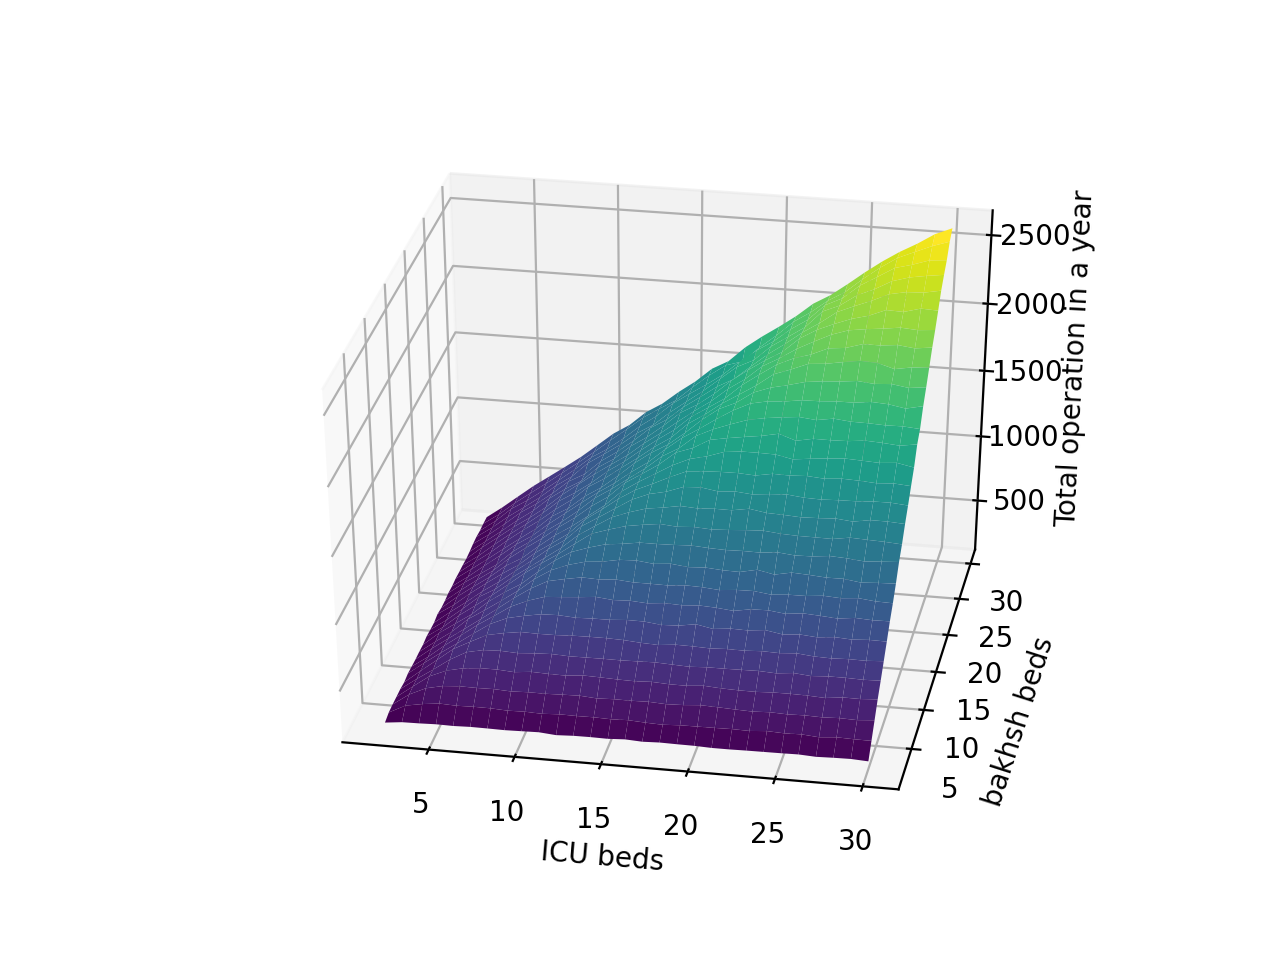

<IPython.core.display.Javascript object>


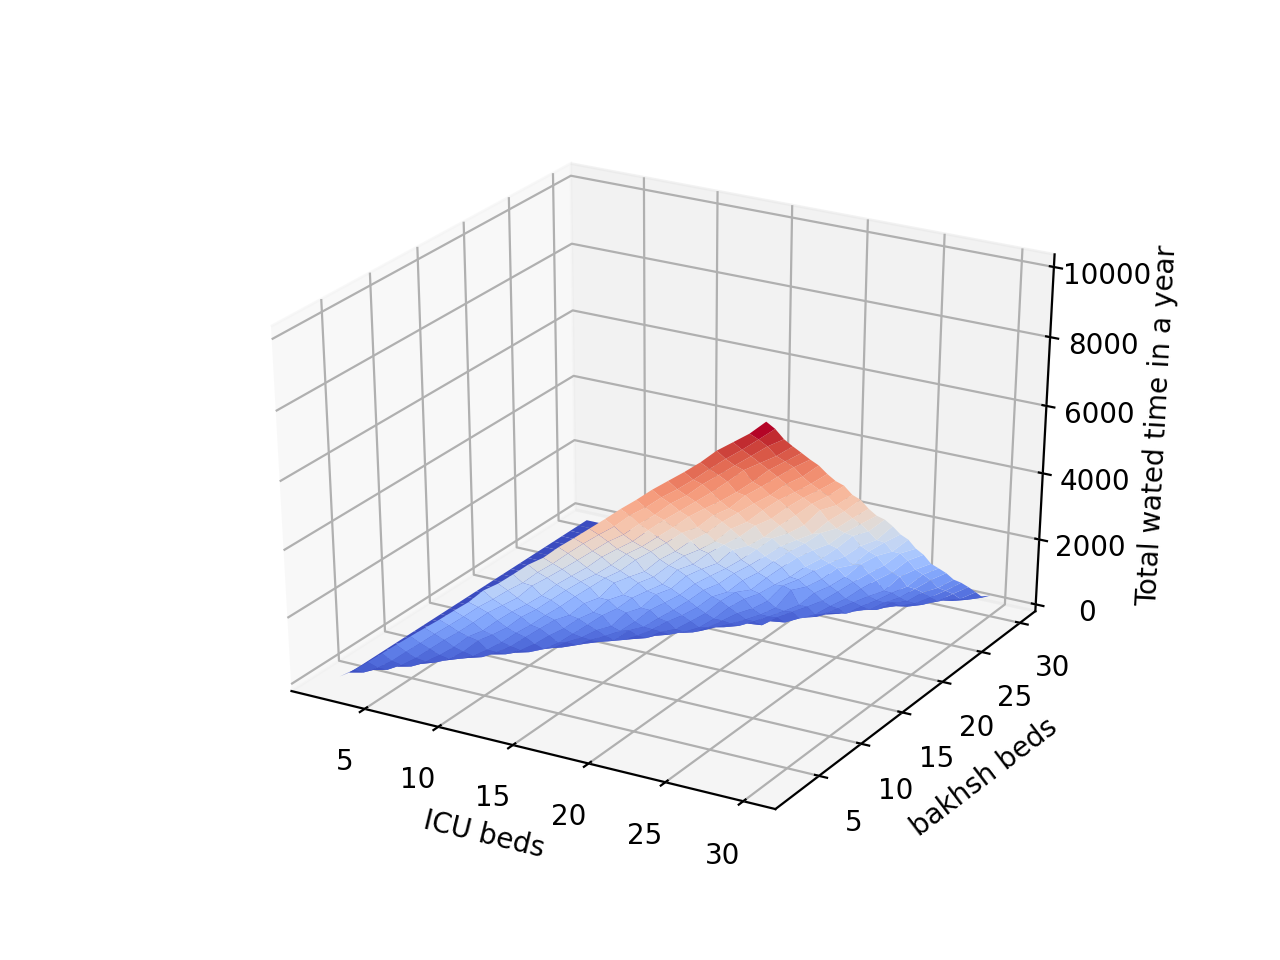

In [68]:
from mpl_toolkits import mplot3d
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(np.linspace(min_bakhsh_beds, max_bakhsh_beds, max_bakhsh_beds - min_bakhsh_beds + 1),
                   np.linspace(min_icu_beds, max_icu_beds, max_icu_beds - min_icu_beds + 1))

ax.plot_surface(X, Y, operations, cmap='viridis')
ax.set_xlabel('ICU beds')
ax.set_ylabel('bakhsh beds')
ax.set_zlabel('Total operation in a year');

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, wasted_time,cmap='coolwarm')
ax.set_xlabel('ICU beds')
ax.set_ylabel('bakhsh beds')
ax.set_zlabel('Total wated time in a year');


plt.show()